In [100]:
# 라이브러리
import os
import re
import random
import math
import cv2

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Add, AveragePooling2D
from tensorflow.keras.models import Model

import warnings

warnings.filterwarnings(action='ignore')

In [101]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [102]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [103]:
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

In [104]:
# parameter
BATCH_SIZE = 16
EPOCHS = 25


In [182]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH  = ROOT_PATH + '/chest_xray/data/test/*/*'

In [106]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [107]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


val 양이 적어 train과 합친 후, 재 편성

In [108]:
# data combine
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# data split
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state =8 )

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [109]:
# cnt norm & pneu
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print('Normal images count in training set :', str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('Pneumonia images count in training set :', str(COUNT_PNEUMONIA))

Normal images count in training set : 1084
Pneumonia images count in training set : 3101


tf.data는 데이터 입력 파이프 라인 빌드를 위한 텐서플로우의 서브패키지, 혹은 다른 말로 API이다.

로컬 파일이나 메모리에 올려져 있는 데이터를 모델에 집어넣기 적합한 텐서로 변환하는 작업을 한다.

하위 tf.data.dataset 은 tf.data의 추상 클래스로써 데이터의 병렬 처리가 용이한 형태, 즉 GPU가 연산이 끝나면 다음 데이터를 바로바로 가져다가(Pre-Fetch) 빠르게 처리할 수 있도록 고안되었다.

Numpy나 Pandas, 혹은 Tensorflow 2.0 부터된 아예 통합된 Keras 등 모델에 집어넣기 위해 데이터 전처리(Pre-Processing) 용도로 자주 쓰이고 그만큼 유명한 여러 모듈들이 있다.
하지만 텐서플로우에서 제공하는 tf.data.dataset 클래스가 성능적으로는 가장 최적화되어 있다고 볼 수 있다.

https://hiseon.me/data-analytics/tensorflow/tensorflow-dataset/

In [110]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [111]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [112]:
# 경로내 이름을 통한 label 분류
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [113]:
# data size 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [114]:
# 경로를 입력시 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [115]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [116]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)  # (180, 180, 3)
    print("Label: ", label.numpy())  # False

Image shape:  (180, 180, 3)
Label:  False


In [37]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)  # 624

624


In [56]:
def prepare_for_training(ds, batch_size=BATCH_SIZE, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 시각화

In [39]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, batch_size=16):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,math.ceil(batch_size/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

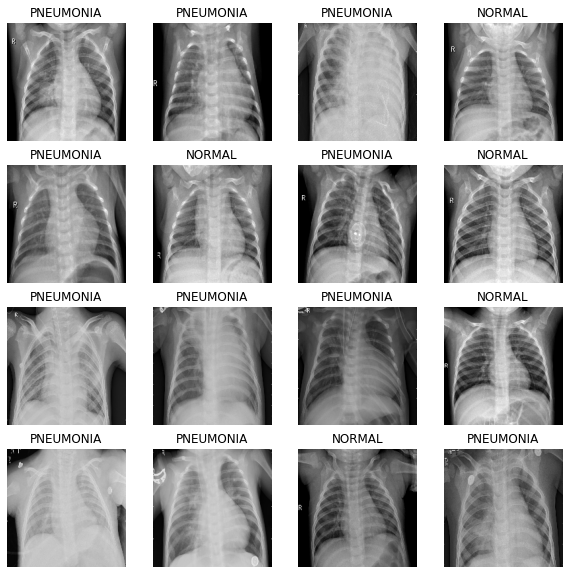

In [41]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

In [42]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))  # 1.95
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))  # 0.67

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [46]:
def model_setting(device_setting='/GPU:0'):
    with tf.device(device_setting):
        model = build_model()

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',  # 이미지, 라벨 2개밖에 없어서 binary_cross entrophy loss 사용
            metrics=METRICS  # 성과 측정 매트릭스: 'accuracy', 'precision', 'recall'
        )

        return model

In [47]:
model = model_setting()

In [48]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [49]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 66s 202ms/step - loss: 0.3522 - accuracy: 0.8360 - precision: 0.9585 - recall: 0.8140 - val_loss: 0.7633 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 52s 201ms/step - loss: 0.2322 - accuracy: 0.9100 - precision: 0.9722 - recall: 0.9043 - val_loss: 1.2849 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 53s 203ms/step - loss: 0.2031 - accuracy: 0.9200 - precision: 0.9743 - recall: 0.9164 - val_loss: 0.5449 - val_accuracy: 0.7827 - val_precision: 0.7747 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 54s 206ms/step - loss: 0.1988 - accuracy: 0.9332 - precision: 0.9757 - recall: 0.9331 - val_loss: 0.2773 - val_accuracy: 0.9058 - val_precision: 0.9942 - val_recall: 0.8790
Epoch 5/25
261/261 [==============================] - 55s 209ms/step - loss: 0.1635 - accura

In [50]:
def draw_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

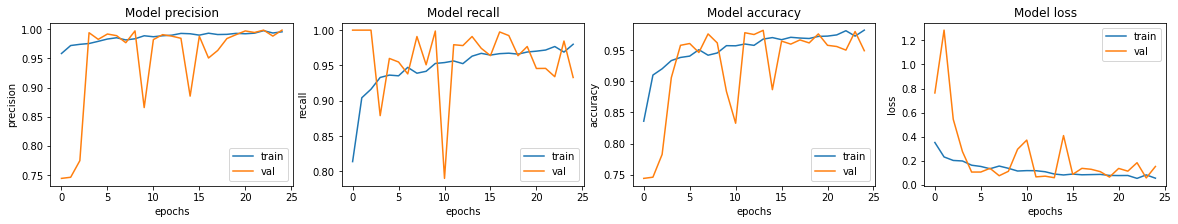

In [51]:
draw_history(history)

In [52]:
def print_evaluation(model, test_ds):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss:.2f},\nAccuracy: {accuracy:.2f},\nPrecision: {precision:.2f},\nRecall: {recall:.2f}')

In [53]:
print_evaluation(model, test_ds)

39/39 [==============================] - 4s 108ms/step - loss: 0.5328 - accuracy: 0.8734 - precision: 0.8494 - recall: 0.9692
Loss: 0.53,
Accuracy: 0.87,
Precision: 0.85,
Recall: 0.97


# 참고자료

https://hnsuk.tistory.com/31

https://haystar.tistory.com/94

https://hwanny-yy.tistory.com/12
